In [39]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import coo_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pickle
%matplotlib inline

import torch
from torch.distributions import constraints
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam, SGD

In [4]:
assert pyro.__version__.startswith('1.8.6')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = True

In [107]:
name = "GHZ_2"
filename = name+"_counts"
path = "data/"+filename
outcomes = {}
with open(filename, "r") as f:
    lines = f.read().splitlines()
for line in lines:
    outcome, freq = line.split(" ")
    number = int(outcome, 2)
    outcomes[number] = int(freq)
print(outcomes)

#creates a shuffled list of the measurement results in proportion
data = []
for outcome in outcomes:
    data += [outcome]*outcomes[outcome]
random.shuffle(data)

{3: 5014, 0: 4986}


In [108]:
class QuantumStateTomography(nn.Module):
    def __init__(self, N=3, alpha = 1, K=3, POVM="standard", sigma = 1):
        super().__init__()
        #define hyperparameters
        self.N = 2**N        # size of system (2^num qubits)
        self.alpha = alpha   # sparsity of the density matrix
        self.K = K           # rank of the density matrix
        self.POVM = POVM     # measurement set used
        self.sigma = sigma   # variance of the complex vectors

    def model(self, data):
        theta = pyro.sample("theta", dist.Dirichlet(torch.ones(self.K)*self.alpha))
        with pyro.plate("pure states", self.K):
            real_part = pyro.sample("real_part", dist.MultivariateNormal(torch.zeros(self.N),self.sigma*torch.eye(self.N)))
            imag_part = pyro.sample("imag_part", dist.MultivariateNormal(torch.zeros(self.N),self.sigma*torch.eye(self.N)))
            complex_vector = torch.complex(real_part, imag_part)
            norm_vector = complex_vector / torch.norm(complex_vector, dim=-1, keepdim=True)
        theta_diag = torch.diag(theta).type(torch.complex64)
        norm_vector_hat = torch.conj(torch.transpose(norm_vector, 0,1))
        density_matrix = torch.matmul(torch.matmul(norm_vector_hat, theta_diag), norm_vector)
        
        ### Alternate way of computing the density matrix
        # density_matrix = torch.zeros((self.N,self.N), dtype=torch.complex64)
        # for i in range(self.K):
        #     vec = norm_vector[i]
        #     vec_hat = torch.conj(vec)
        #     density_matrix += theta[i].type(torch.complex64) * torch.outer(vec,vec_hat)
        
        # print(density_matrix.shape)
        # print(density_matrix)
        #rho = pyro.sample("Density Matrix", dist.Delta(density_matrix, event_dim=2))
        rho = density_matrix
        #in principle we could apply any POVM measurement set upon this density matrix using traces

        if self.POVM == "standard":
            #standard basis measurements
            with pyro.plate('data', len(data)):
                return pyro.sample("obs", dist.Categorical(torch.diagonal(rho).real), obs=data)
        else:
            #TBD
            with pyro.plate('data', len(data)):
                return pyro.sample("obs", dist.Categorical(torch.diagonal(rho).real), obs=data)

In [110]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test
def setup_data_loaders(data, batch_size=128, use_cuda=False):
    root = './data'
    download = True
    random.shuffle(data)
    n = len(data)
    cutoff = int(0.9*n)
    train_set = torch.Tensor(data[:cutoff])
    test_set = torch.Tensor(data[cutoff:])

    kwargs = {'num_workers': 4, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [112]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False
smoke_test = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 10

In [113]:
train_loader, test_loader = setup_data_loaders(data,batch_size=20, use_cuda=USE_CUDA)
n_qubits = 2
n_states = 1
# clear param store
pyro.clear_param_store()

qst = QuantumStateTomography(N=n_qubits, K=n_states)
optimizer = Adam({"lr": LEARNING_RATE})
guide = pyro.infer.autoguide.AutoNormal(qst.model)
svi = SVI(qst.model, guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    pbar.set_description("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        pbar.set_description("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 099]  average training loss: 1.3152: 100%|█| 100/100 [03:27<00:00,  2.07s


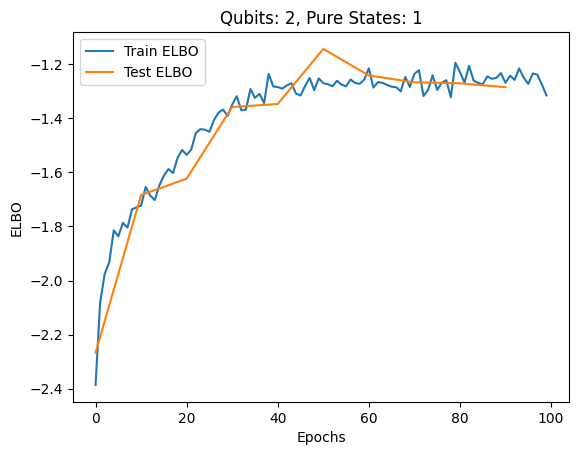

In [114]:
epochs = np.arange(len(train_elbo))
plt.plot(epochs, train_elbo, label='Train ELBO')
epochs = np.arange(len(test_elbo))
plt.plot(epochs*TEST_FREQUENCY, test_elbo, label='Test ELBO')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.title(f"Qubits: {n_qubits}, Pure States: {n_states}")
plt.show()

In [115]:
#for name, value in pyro.get_param_store().items():
    #print(name, pyro.param(name).data.cpu().numpy())

In [116]:
from scipy.linalg import sqrtm
def trace_dist(a, b):
    k = a-b
    M = np.matmul(k.conj().T,k)
    B = sqrtm(M)
    return np.trace(B)/2

In [119]:
real_part = pyro.param('AutoNormal.locs.real_part').data[0]
imag_part = pyro.param('AutoNormal.locs.imag_part').data[0]
print("norm", torch.norm(torch.complex(real_part, imag_part)))
vec = torch.complex(real_part, imag_part) / torch.norm(torch.complex(real_part, imag_part))
approx_DM = torch.outer(vec, torch.conj(vec)).numpy()

with open("data/GHZ_2_density", "rb") as file:
    rho = pickle.load(file)
true_DM = rho.data

print('Trace Distance:',trace_dist(approx_DM, true_DM).real)
#pretty terrible!

approx_prob = np.round(np.real(np.diag(approx_DM)),3)
real_prob = np.round(np.real(np.diag(true_DM)),3)
print('approx:',approx_prob)
print('real:', real_prob)

print(np.round(approx_prob - real_prob,3))

norm tensor(0.5609)
Trace Distance: 0.40683413652534806
approx: [0.867 0.001 0.    0.131]
real: [0.5 0.  0.  0.5]
[ 0.367  0.001  0.    -0.369]
